# Multiple model classification of personality types

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression as LR
import pandas as pd
from functools import partial
import re
import spacy
from itertools import tee
from sklearn.model_selection import train_test_split

In [20]:
#Load spacy model
nlp = spacy.load("en_core_web_sm")

In [21]:
#Import data
df = pd.read_csv('../../data/essays - essays.csv')

In [22]:
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,1997_568848.txt,I can't believe it! It's really happening! M...,y,n,y,y,n
4,1997_688160.txt,"Well, here I go with the good old stream of co...",y,n,y,n,y


In [23]:
#Replace string representations of target variables to boolean
df['cEXT'] = df['cEXT'].map({'n': 0, 'y': 1})
df['cNEU'] = df['cNEU'].map({'n': 0, 'y': 1})
df['cAGR'] = df['cAGR'].map({'n': 0, 'y': 1})
df['cCON'] = df['cCON'].map({'n': 0, 'y': 1})
df['cOPN'] = df['cOPN'].map({'n': 0, 'y': 1})
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,1997_568848.txt,I can't believe it! It's really happening! M...,1,0,1,1,0
4,1997_688160.txt,"Well, here I go with the good old stream of co...",1,0,1,0,1


### Sentiment represenatation of text

For sentiment analysis of given essays Vader library is used. This library gives each word in text a score depending on if it is considered positive or negative. Final score is given as a normalized sum.

In [24]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ilinardic\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
sid = SentimentIntensityAnalyzer()
vader=lambda x: sid.polarity_scores(x)['compound']

df['vader_review'] = df['TEXT'].apply(vader)

In [26]:
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN,vader_review
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1,0.9982
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",0,0,1,0,0,0.9978
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,0,1,0,1,1,0.9659
3,1997_568848.txt,I can't believe it! It's really happening! M...,1,0,1,1,0,0.9961
4,1997_688160.txt,"Well, here I go with the good old stream of co...",1,0,1,0,1,0.9896


### Text preprocessing

In [27]:
def lemmatizer(text):
    """
    Receives a string as an input and lemmatizes it.
    The lemmas are returned in a list.
    """
    lemmas = nlp(text)
    return [token.lemma_ for token in lemmas]


def ngrams(sequence, n, **kwargs):
    """
    Receives a list of tokens and generates n-grams.
    """
    seq_len = len(sequence)
    num_of_ngrams = seq_len-n+1
    iti = iter(sequence)
    it = tee(iti, num_of_ngrams)
    tuple_list = []
    for i in range(num_of_ngrams):  #iterate over iterators
        list_to_create_tuple = []
        for j, w in enumerate(it[i]):   #iterate over iterator to create a touple
            if i+n > seq_len or j >= i+n:
                break
            if j >= i:
                list_to_create_tuple.append(w)
        tuple_list.append(tuple(list_to_create_tuple))

    return tuple_list


def clean_text(text):
    """
    Replaces all whitespaces with single spaces.
    Returns preprocessed text.
    """
    return re.sub(r'\s+', ' ', text)




In [28]:
stop_words = nlp.Defaults.stop_words

def lemmatize_pipe(doc, max_len, ngram_min, ngram_max):
    """
    Removes stopword, truncates the document to `max_len` tokens,
    and returns lemma n-grams in range [`ngram_min`, `ngram_max`].
    """
    doc_without_sw = [token for token in doc if not token.text.lower() in stop_words]
    doc_without_sw_trunc = doc_without_sw[:max_len]
    result_list = []
    for n in range(ngram_min,ngram_max+1):
        result_list = result_list + ngrams([token.lemma_ for token in doc_without_sw_trunc], n)

    return result_list


def preprocess_pipe(texts, pipe_fn):
    processed_list = []
    for doc in nlp.pipe(texts):
        processed_list.append(pipe_fn(doc))
    return processed_list

In [29]:
pipe_fn = partial(lemmatize_pipe, max_len=100, ngram_min=1, ngram_max=2)

In [30]:
pipe_fn = partial(lemmatize_pipe, max_len=100, ngram_min=3, ngram_max=3)

In [31]:
df['lemmas'] = preprocess_pipe(df.TEXT, pipe_fn)

In [32]:
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN,vader_review,lemmas
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1,0.9982,"[(,, right, wake), (right, wake, mid), (wake, ..."
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",0,0,1,0,0,0.9978,"[(,, stream, consciousness), (stream, consciou..."
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,0,1,0,1,1,0.9659,"[(open, keyboard, button), (keyboard, button, ..."
3,1997_568848.txt,I can't believe it! It's really happening! M...,1,0,1,1,0,0.9961,"[(believe, !, ), (!, , happen), ( , happen, ..."
4,1997_688160.txt,"Well, here I go with the good old stream of co...",1,0,1,0,1,0.9896,"[(,, good, old), (good, old, stream), (old, st..."


In [38]:
df_train_ext, df_test_ext = train_test_split(
    df[["lemmas", "vader_review", "cEXT"]], test_size=0.2, random_state=42
)
df_train_neu, df_test_neu = train_test_split(
    df[["lemmas", "vader_review", "cNEU"]], test_size=0.2, random_state=42
)
df_train_agr, df_test_agr = train_test_split(
    df[["lemmas", "vader_review", "cAGR"]], test_size=0.2, random_state=42
)
df_train_con, df_test_con = train_test_split(
    df[["lemmas", "vader_review", "cCON"]], test_size=0.2, random_state=42
)
df_train_opn, df_test_opn = train_test_split(
    df[["lemmas", "vader_review", "cOPN"]], test_size=0.2, random_state=42
)

In [39]:
# Load vectorizers
count_vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, min_df=3)
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False, min_df=3)

In [52]:
df_TFIDF = df[['lemmas', 'vader_review']]
df_COUNT = df[['lemmas', 'vader_review']]

### Model training

In [53]:
count_matrix = count_vectorizer.fit_transform(df_COUNT.lemmas)
count_df = pd.DataFrame(count_matrix.toarray())
count_df['vader_review'] = df_COUNT['vader_review']

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [54]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df_TFIDF.lemmas)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray())
tfidf_df['vader_review'] = df_TFIDF['vader_review']

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [59]:
count_df.columns = count_df.columns.astype(str)
tfidf_df.columns = tfidf_df.columns.astype(str)

In [56]:
def train_lr(X_train, y_train, lr_kwargs={"max_iter": 1000, "solver": "lbfgs"}):
    """
    Receives the train set and uses it to train a logistic regression with
    training arguments passed as `lr_kwargs`.
    Returns the fitted model.
    """
    model = LR(**lr_kwargs).fit(X_train,y_train)
    return model

In [57]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def test_performance(X_test, y_test, model):
    y_pred = model.predict(X_test)
    print(classification_report(y_pred=y_pred, y_true=y_test))
    return f1_score(y_pred=y_pred, y_true=y_test, average="macro")

In [81]:
count_f1_values = []
tf_idf_f1_values = []

##### Count vectorizer scenario

In [82]:
#Extroverted
df_y = df[["cEXT"]]
X_train, X_test, y_train, y_test = train_test_split(count_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
count_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.45      0.45      0.45       227
           1       0.53      0.53      0.53       267

    accuracy                           0.49       494
   macro avg       0.49      0.49      0.49       494
weighted avg       0.49      0.49      0.49       494


f1 = 0.489



In [83]:
#Neuroticism
df_y = df[["cNEU"]]
X_train, X_test, y_train, y_test = train_test_split(count_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
count_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.57      0.57      0.57       260
           1       0.52      0.52      0.52       234

    accuracy                           0.54       494
   macro avg       0.54      0.54      0.54       494
weighted avg       0.54      0.54      0.54       494


f1 = 0.541



In [84]:
#Agreeableness
df_y = df[["cAGR"]]
X_train, X_test, y_train, y_test = train_test_split(count_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
count_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.46      0.44      0.45       220
           1       0.57      0.59      0.58       274

    accuracy                           0.52       494
   macro avg       0.52      0.52      0.52       494
weighted avg       0.52      0.52      0.52       494


f1 = 0.515



In [85]:
#Consciousness
df_y = df[["cCON"]]
X_train, X_test, y_train, y_test = train_test_split(count_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
count_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.50      0.60      0.55       227
           1       0.59      0.49      0.54       267

    accuracy                           0.54       494
   macro avg       0.55      0.55      0.54       494
weighted avg       0.55      0.54      0.54       494


f1 = 0.544



In [86]:
#Openness
df_y = df[["cOPN"]]
X_train, X_test, y_train, y_test = train_test_split(count_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
count_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.52      0.46      0.49       237
           1       0.55      0.61      0.58       257

    accuracy                           0.54       494
   macro avg       0.54      0.54      0.53       494
weighted avg       0.54      0.54      0.54       494


f1 = 0.534



##### Tf-Idf vectorizer scenario

In [87]:
#Extroverted
df_y = df[["cEXT"]]
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
tf_idf_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.47      0.44      0.45       227
           1       0.55      0.58      0.57       267

    accuracy                           0.52       494
   macro avg       0.51      0.51      0.51       494
weighted avg       0.51      0.52      0.51       494


f1 = 0.510



In [88]:
#Neuroticism
df_y = df[["cNEU"]]
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
tf_idf_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.58      0.55      0.57       260
           1       0.53      0.56      0.54       234

    accuracy                           0.55       494
   macro avg       0.55      0.55      0.55       494
weighted avg       0.56      0.55      0.55       494


f1 = 0.554



In [89]:
#Agreeableness
df_y = df[["cAGR"]]
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
tf_idf_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.49      0.36      0.42       220
           1       0.58      0.70      0.63       274

    accuracy                           0.55       494
   macro avg       0.53      0.53      0.52       494
weighted avg       0.54      0.55      0.54       494


f1 = 0.525



In [90]:
#Consciousness
df_y = df[["cCON"]]
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
tf_idf_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.51      0.56      0.53       227
           1       0.59      0.54      0.56       267

    accuracy                           0.55       494
   macro avg       0.55      0.55      0.55       494
weighted avg       0.55      0.55      0.55       494


f1 = 0.546



In [91]:
#Openness
df_y = df[["cOPN"]]
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df_y, test_size=0.2, random_state=42)

lr_ext = train_lr(X_train=X_train, y_train=y_train)
f1 = test_performance(X_test=X_test, y_test=y_test, model=lr_ext)
tf_idf_f1_values.append(f1)
print(f"\nf1 = {f1:.3f}\n")

C:\Users\ilinardic\Documents\FER\ATR\project\TAR-project-2023\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.52      0.46      0.49       237
           1       0.55      0.61      0.58       257

    accuracy                           0.54       494
   macro avg       0.54      0.54      0.54       494
weighted avg       0.54      0.54      0.54       494


f1 = 0.536



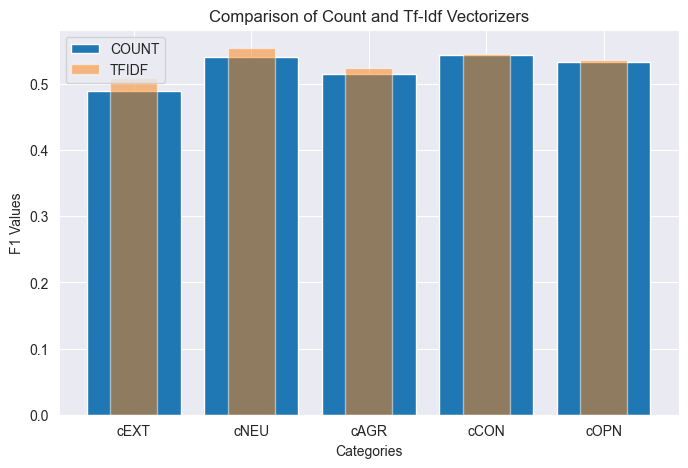

In [96]:
import matplotlib.pyplot as plt

labels = ["cEXT", "cNEU", "cAGR", "cCON", "cOPN"]

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(labels, count_f1_values, label='COUNT')
ax.bar(labels, tf_idf_f1_values, label='TFIDF', alpha=0.5, width=0.4)

ax.set_xlabel('Categories')
ax.set_ylabel('F1 Values')
ax.set_title('Comparison of Count and Tf-Idf Vectorizers')

ax.legend()

plt.show()